In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import r2_score

In [26]:
data = pd.read_csv("/kaggle/input/stock/TSLA.csv")
data = data.iloc[::-1].reset_index(drop=True)
data.drop(columns=['Date'], inplace=True)
data['time'] = data.index + 1

# 移除 'Change %' 中的 '%' 符號
data['Change %'] = data['Change %'].str.replace('%', '', regex=False).astype(float)

def convert_vol(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    return float(value)  # 如果沒有 'K' 或 'M'，直接轉換為浮點數

data['Vol.'] = data['Vol.'].apply(convert_vol)

In [27]:
split_index = len(data) - 120 # int(len(data) * 0.8)  # 80%的位置

# 創建訓練集和測試集
train_data = data[:split_index]
test_data = data[split_index:]

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 2396
Test data length: 120


In [28]:
group_size = 500  # 每個組的大小
step_size = 20  # 每次迴圈的增量

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假設 train_groups 是你已經劃分好的訓練數據集
# 'features' 是你需要預測的欄位名稱
features = ['Price', 'Open', 'High', 'Low', 'Vol.']
def make_model():
    models = {feature: SVR(kernel='rbf', C=10000, epsilon=0.00001) for feature in features}  # 為每個特徵創建一個模型

    # 創建每個特徵的 X 和 y 集合
    X_train_by_feature = {feature: [] for feature in features}
    y_train_by_feature = {feature: [] for feature in features}

    # 訓練過程，使用 for i 循環每次取 i ~ i + group_size

    # for i 遍歷每個訓練組的起始索引，i 會從 0 開始，然後每次增長 step_size
    for i in range(0, len(data) - group_size, step_size):
        group = data.iloc[i:i + group_size]  # 取出每個訓練組
        X1 = group.iloc[:group_size-1][features].values  # 前 group_size-1 天的資料
        y1 = group.iloc[group_size-1][features].values  # 第 group_size 天的資料作為目標

        # 將 group_size-1 天的資料合併成一個長向量
        X1_combined = X1.flatten()  # 把資料展開為一個長向量

        # 收集每個特徵的 X 和 y
        for i, feature in enumerate(features):
            X_train_by_feature[feature].append(X1_combined)  # 收集 X
            y_train_by_feature[feature].append(y1[i])  # 收集 y

    # 批量訓練每個特徵的模型
    for feature in features:
        X_train = np.array(X_train_by_feature[feature])  # 將收集的 X 轉為 numpy 陣列
        y_train = np.array(y_train_by_feature[feature])  # 將收集的 y 轉為 numpy 陣列
        models[feature].fit(X_train, y_train)  # 訓練模型
    return models

In [30]:
"""
# 取出最後8個樣本的特徵
last_9_data = data.iloc[-(group_size-1):][features].values  # 取出最後8個樣本的特徵

# 合併為一個長向量 (1D 陣列)
X_combined = last_9_data.flatten()  # 轉換為 1D 陣列

# 用來存放預測結果的列表
predictions = []

# 為每個特徵進行預測
for i, feature in enumerate(features):
    # 使用對應的模型進行預測
    prediction = models[feature].predict(poly.transform(X_combined.reshape(1, -1)))  # 這裡進行一次reshape使得符合模型要求
    predictions.append(prediction[0])  # 預測結果是陣列，所以取出第一個值

# 將預測結果轉換成 DataFrame
pred_df = pd.DataFrame([predictions], columns=features)

# 顯示預測結果
print("predict")
print(pred_df)

# 取出 test_data 的第一行並去掉 'time' 列
test_data_first_row = test_data.iloc[0][['Price', 'Open', 'High', 'Low', 'Vol.']]

# 反標準化
# test_data_first_row = MinMaxScaler().inverse_transform(test_data_first_row.reshape(-1, 1)).flatten()

# 轉換為 DataFrame 顯示為行的形式
test_data_first_row = np.array(test_data_first_row) * (y_max - y_min) + y_min
test_data_first_row_df = pd.DataFrame(test_data_first_row, index=['Price', 'Open', 'High', 'Low', 'Vol.'])

# 顯示第一行數據
print("test")
print(test_data_first_row_df)
"""

'\n# 取出最後8個樣本的特徵\nlast_9_data = data.iloc[-(group_size-1):][features].values  # 取出最後8個樣本的特徵\n\n# 合併為一個長向量 (1D 陣列)\nX_combined = last_9_data.flatten()  # 轉換為 1D 陣列\n\n# 用來存放預測結果的列表\npredictions = []\n\n# 為每個特徵進行預測\nfor i, feature in enumerate(features):\n    # 使用對應的模型進行預測\n    prediction = models[feature].predict(poly.transform(X_combined.reshape(1, -1)))  # 這裡進行一次reshape使得符合模型要求\n    predictions.append(prediction[0])  # 預測結果是陣列，所以取出第一個值\n\n# 將預測結果轉換成 DataFrame\npred_df = pd.DataFrame([predictions], columns=features)\n\n# 顯示預測結果\nprint("predict")\nprint(pred_df)\n\n# 取出 test_data 的第一行並去掉 \'time\' 列\ntest_data_first_row = test_data.iloc[0][[\'Price\', \'Open\', \'High\', \'Low\', \'Vol.\']]\n\n# 反標準化\n# test_data_first_row = MinMaxScaler().inverse_transform(test_data_first_row.reshape(-1, 1)).flatten()\n\n# 轉換為 DataFrame 顯示為行的形式\ntest_data_first_row = np.array(test_data_first_row) * (y_max - y_min) + y_min\ntest_data_first_row_df = pd.DataFrame(test_data_first_row, index=[\'Price\', \'Op

In [31]:
def make_predict(model):
    # 設定迭代次數
    iterations = len(test_data)
    
    # 用來存放每次的預測結果
    all_predictions = []
    
    # 複製原始的 last_8_data 以便進行逐步更新
    last_9_data = data.iloc[-(group_size-1):][features].values
    updated_last_9_data = last_9_data.copy()
    
    # 進行迭代預測
    for step in range(iterations):
        # 合併為一個長向量 (1D 陣列)
        X_combined = updated_last_9_data.flatten()  # 轉換為 1D 陣列
        
        # 用來存放當前步驟的預測值
        step_prediction = []
        
        # 為每個特徵進行預測
        for feature in features:
            prediction = models[feature].predict(X_combined.reshape(1, -1))  # 預測
            step_prediction.append(prediction[0])  # 取出預測結果
        
        # 將當前步驟的預測結果存入總結果列表
        all_predictions.append(step_prediction)
        
        # 丟掉 last_8_data 的第一個樣本，將新的預測結果插入到最後
        updated_last_9_data = np.vstack([updated_last_9_data[1:], step_prediction])  # 更新資料
        #updated_last_9_data = np.vstack([updated_last_9_data[1:], test_data.iloc[step][['Price', 'Open', 'High', 'Low', 'Vol.']].to_numpy().reshape(1, -1)])  # 更新資料
    
    # 將所有預測結果轉換成 DataFrame
    all_predictions_df = pd.DataFrame(all_predictions, columns=features)
    all_predictions_df['time'] = range(len(train_data), len(train_data) + len(all_predictions_df))
    # 顯示前幾步的預測結果
    all_predictions_df
    return all_predictions_df

In [60]:
def make_draw(all_predictions_df):
    import matplotlib.pyplot as plt
    
    # 假設 test_data 已經有 'time' 欄位
    
    # 繪製圖表
    plt.figure(figsize=(10, 6))
    
    # 繪製真實價格
    plt.plot(test_data['time'], test_data['Price'], label='Actual Price', linestyle='-')
    
    # 繪製預測價格
    plt.plot(all_predictions_df['time'], all_predictions_df['Price'], label='Predicted Price',linestyle='--')
    
    plt.ylim(0, 400)
    # 添加標籤與圖例
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.ylim(150, 280)
    plt.legend()
    plt.grid(True)
    
    # 顯示圖表
    plt.show()

In [33]:
def make_MAPE(all_predictions_df):
    
    true_values = test_data["Price"].to_numpy()
    predicted_values = all_predictions_df["Price"].to_numpy()
    
    # 計算 MAPE
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    
    #print(f"MAPE: {mape:.2f}%")
    return mape

i = 0 group_size = 674 step_size = 41 mape = 14.556946506268137
i = 50 group_size = 606 step_size = 38 mape = 10.025870555698702
i = 100 group_size = 641 step_size = 78 mape = 14.98094732324122
i = 150 group_size = 538 step_size = 35 mape = 34.77890866752324
i = 200 group_size = 512 step_size = 63 mape = 16.469615559404772
i = 250 group_size = 583 step_size = 86 mape = 8.944811620187027
i = 300 group_size = 556 step_size = 68 mape = 9.066640884340577
i = 350 group_size = 520 step_size = 23 mape = 26.650305048360543
i = 400 group_size = 559 step_size = 41 mape = 18.203955740828608
i = 450 group_size = 600 step_size = 33 mape = 9.196221501690086
i = 500 group_size = 500 step_size = 39 mape = 26.772988952455933
i = 550 group_size = 549 step_size = 39 mape = 19.34653393260287
i = 600 group_size = 585 step_size = 93 mape = 10.614614599375368
i = 650 group_size = 616 step_size = 54 mape = 17.154285563168635
i = 700 group_size = 653 step_size = 28 mape = 16.490084330529772
i = 750 group_size 

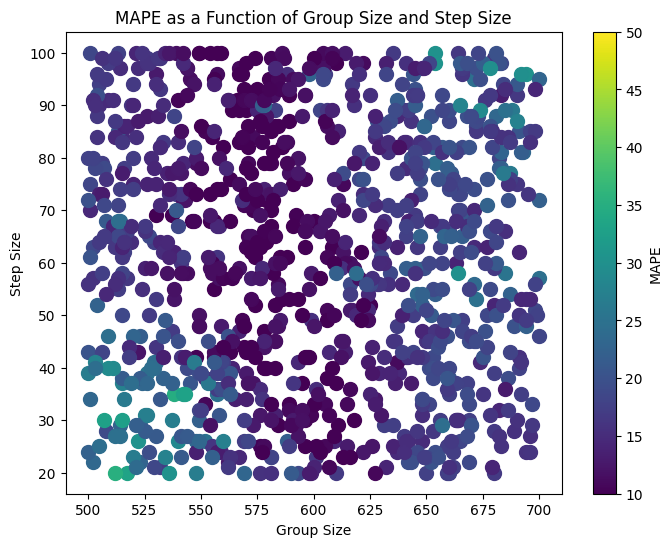

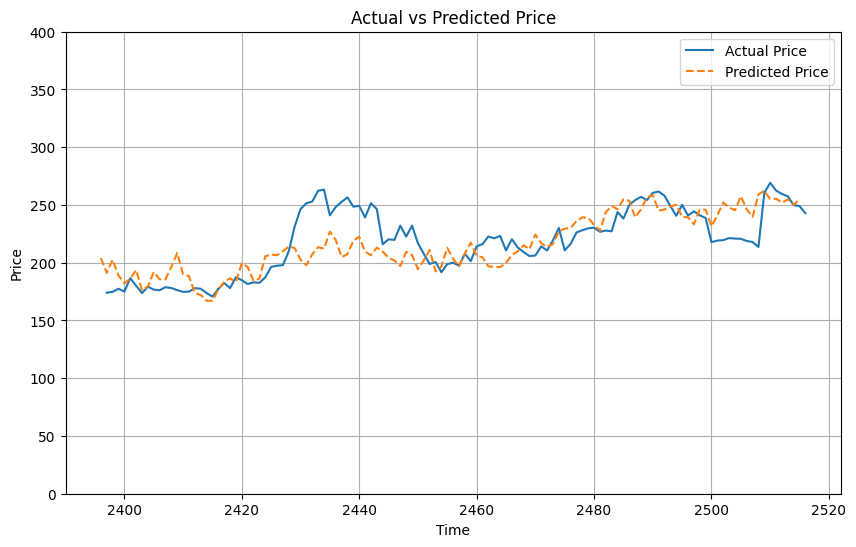

min_mape = 6.448093400793107
best_group_size = 595
best_step_size = 50
59


In [54]:
min_mape = 1e8
best_group_size = 0
best_step_size = 0

fig, ax = plt.subplots(figsize=(8, 6))
mape_values = []
max_correct = 0

for i in range(1000):
    group_size = random.randint(500, 700)
    step_size = random.randint(20, 100)
    models = make_model()
    all_predictions_df = make_predict(models)
    mape = make_MAPE(all_predictions_df)
    correct = 0
    for j in range(len(test_data['time']) - 1):
        if (test_data['Price'].to_numpy()[j + 1] - test_data['Price'].to_numpy()[j]) * (all_predictions_df['Price'].to_numpy()[j + 1] - all_predictions_df['Price'].to_numpy()[j]) > 0:
            correct = correct + 1
    if(i%50 == 0):
        print("i =", i,"group_size =", group_size,"step_size =", step_size,"mape =", mape)

    if mape < min_mape:
        min_mape = mape
        best_group_size = group_size
        best_step_size = step_size
        max_correct = correct

    ax.scatter(group_size, step_size, c=mape, cmap='viridis', s=100,vmin=10, vmax=50)

# 添加顏色條
plt.colorbar(ax.collections[0], label='MAPE')

# 設定標籤
ax.set_xlabel('Group Size')
ax.set_ylabel('Step Size')

# 顯示圖形
plt.title('MAPE as a Function of Group Size and Step Size')
plt.show()    


group_size = best_group_size
step_size = best_step_size
models = make_model()
all_predictions_df = make_predict(models)
mape = make_MAPE(all_predictions_df)
make_draw(all_predictions_df)

print("min_mape =", min_mape)
print("best_group_size =", best_group_size)
print("best_step_size =", best_step_size)
print(correct)

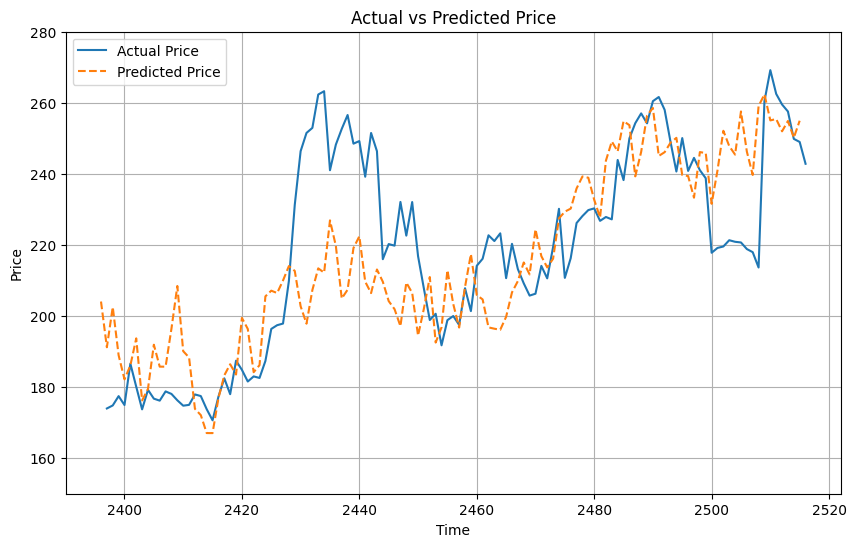

0.5333333333333333
mape = 6.448093400793107


In [61]:
group_size = 595  # 每個組的大小
step_size = 50  # 每次迴圈的增量
models = make_model()
all_predictions_df = make_predict(models)
mape = make_MAPE(all_predictions_df)
make_draw(all_predictions_df)

correct = 0
for i in range(len(test_data['time']) - 1):
    if (test_data['Price'].to_numpy()[i + 1] - test_data['Price'].to_numpy()[i]) * (all_predictions_df['Price'].to_numpy()[i + 1] - all_predictions_df['Price'].to_numpy()[i]) > 0:
        correct = correct + 1

print(correct / len(test_data['time'] - 1))
# print(test_data['Price'].to_numpy())
# r2 = r2_score(test_data['Price'], all_predictions_df['Price'])
print("mape =", mape)
# print(f'R-squared: {r2:.2f}')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 假設 test_data 已經有 'time' 欄位

# 繪製圖表
plt.figure(figsize=(10, 6))

# 繪製真實價格
plt.plot(test_data['time'], test_data['Price'], label='Actual Price', marker='o', linestyle='-')

# 繪製預測價格
plt.plot(all_predictions_df['time'], all_predictions_df['Price'], label='Predicted Price', marker='x', linestyle='--')

plt.ylim(0, 1000)
# 添加標籤與圖例
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

mse = mean_squared_error(test_data['Price'], all_predictions_df['Price'])
r2 = r2_score(test_data['Price'], all_predictions_df['Price'])
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# 顯示圖表
plt.show()
